# VolumeCollection - Working with Volume Groups

A VolumeCollection organizes Volumes with consistent X/Y/Z dimensions. This notebook covers:

- Collection properties and volume-level metadata (`obs`)
- Volume indexing (same patterns as [01_radi_object](./01_radi_object.ipynb#subject-indexing))
- Batch operations and visualization
- Collection Query API

## Key Terminology: obs_id vs obs_subject_id

| Field | Scope | Example | Purpose |
|-------|-------|---------|---------|
| `obs_subject_id` | Per-subject | `"BRATS_001"` | Links volumes across modalities to the same patient |
| `obs_id` | Per-volume (unique) | `"BRATS_001_FLAIR"` | Uniquely identifies each volume in the collection |

A single subject (`obs_subject_id="BRATS_001"`) may have multiple volumes across collections (FLAIR, T1w, T2w), each with a unique `obs_id`.

**Prerequisites:** Run [00_ingest_brats.ipynb](./00_ingest_brats.ipynb) first.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from radiobject import RadiObject, S3Config, configure
from radiobject.data import S3_REGION, get_brats_uri

BRATS_URI = get_brats_uri()
print(f"RadiObject URI: {BRATS_URI}")

In [2]:
# Configure S3 if using S3 URI
if BRATS_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION))

In [3]:
radi = RadiObject(BRATS_URI)
radi

RadiObject(368 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w])

In [4]:
# Access via attribute or method
flair = radi.FLAIR
t1w = radi.collection("T1w")

# Display the collection
flair

VolumeCollection('FLAIR', 368 volumes, shape=240x240x155)

In [5]:
print(f"Shape (X, Y, Z): {flair.shape}")
print(f"Number of volumes: {len(flair)}")
print(f"Volume IDs: {flair.obs_ids}")

Shape (X, Y, Z): (240, 240, 155)
Number of volumes: 368
Volume IDs: ['BraTS20_Training_001_FLAIR', 'BraTS20_Training_002_FLAIR', 'BraTS20_Training_003_FLAIR', 'BraTS20_Training_004_FLAIR', 'BraTS20_Training_005_FLAIR', 'BraTS20_Training_006_FLAIR', 'BraTS20_Training_007_FLAIR', 'BraTS20_Training_008_FLAIR', 'BraTS20_Training_009_FLAIR', 'BraTS20_Training_010_FLAIR', 'BraTS20_Training_011_FLAIR', 'BraTS20_Training_012_FLAIR', 'BraTS20_Training_013_FLAIR', 'BraTS20_Training_014_FLAIR', 'BraTS20_Training_015_FLAIR', 'BraTS20_Training_016_FLAIR', 'BraTS20_Training_017_FLAIR', 'BraTS20_Training_018_FLAIR', 'BraTS20_Training_019_FLAIR', 'BraTS20_Training_020_FLAIR', 'BraTS20_Training_021_FLAIR', 'BraTS20_Training_022_FLAIR', 'BraTS20_Training_023_FLAIR', 'BraTS20_Training_024_FLAIR', 'BraTS20_Training_025_FLAIR', 'BraTS20_Training_026_FLAIR', 'BraTS20_Training_027_FLAIR', 'BraTS20_Training_028_FLAIR', 'BraTS20_Training_029_FLAIR', 'BraTS20_Training_030_FLAIR', 'BraTS20_Training_031_FLAIR', '

In [6]:
# Read essential volume metadata (simplified view)
# For all columns, use: flair.obs.read()
flair.obs.read(columns=["obs_id", "obs_subject_id", "series_type", "dimensions", "voxel_spacing"])

,obs_subject_id,obs_id,series_type,dimensions,voxel_spacing
0,BraTS20_Training_001,BraTS20_Training_001_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
1,BraTS20_Training_002,BraTS20_Training_002_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
2,BraTS20_Training_003,BraTS20_Training_003_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
3,BraTS20_Training_004,BraTS20_Training_004_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
4,BraTS20_Training_005,BraTS20_Training_005_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
...,...,...,...,...,...
363,BraTS20_Training_365,BraTS20_Training_365_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
364,BraTS20_Training_366,BraTS20_Training_366_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
365,BraTS20_Training_367,BraTS20_Training_367_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
366,BraTS20_Training_368,BraTS20_Training_368_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"


In [7]:
# All available columns (includes full NIfTI header metadata)
print(f"All columns: {flair.obs.columns}")
print("\nEssential columns: obs_id, obs_subject_id, series_type, dimensions, voxel_spacing")

All columns: ['series_type', 'voxel_spacing', 'dimensions', 'datatype', 'bitpix', 'scl_slope', 'scl_inter', 'xyzt_units', 'spatial_units', 'qform_code', 'sform_code', 'axcodes', 'affine_json', 'orientation_source', 'source_path']

Essential columns: obs_id, obs_subject_id, series_type, dimensions, voxel_spacing


In [8]:
# Filter volume metadata
flair.obs.read(columns=["obs_id", "obs_subject_id", "series_type", "dimensions"])

,obs_subject_id,obs_id,series_type,dimensions
0,BraTS20_Training_001,BraTS20_Training_001_FLAIR,FLAIR,"(240, 240, 155)"
1,BraTS20_Training_002,BraTS20_Training_002_FLAIR,FLAIR,"(240, 240, 155)"
2,BraTS20_Training_003,BraTS20_Training_003_FLAIR,FLAIR,"(240, 240, 155)"
3,BraTS20_Training_004,BraTS20_Training_004_FLAIR,FLAIR,"(240, 240, 155)"
4,BraTS20_Training_005,BraTS20_Training_005_FLAIR,FLAIR,"(240, 240, 155)"
...,...,...,...,...
363,BraTS20_Training_365,BraTS20_Training_365_FLAIR,FLAIR,"(240, 240, 155)"
364,BraTS20_Training_366,BraTS20_Training_366_FLAIR,FLAIR,"(240, 240, 155)"
365,BraTS20_Training_367,BraTS20_Training_367_FLAIR,FLAIR,"(240, 240, 155)"
366,BraTS20_Training_368,BraTS20_Training_368_FLAIR,FLAIR,"(240, 240, 155)"


## Volume Indexing

Same patterns as RadiObject: `iloc`, `loc`, `[]`, boolean masks.

In [9]:
# iloc (by position), loc (by obs_id), bracket (shorthand)
print(f"iloc[0]:   {flair.iloc[0]}")
print(f"iloc[0:3]: {len(flair.iloc[0:3])} volumes")
print(f"loc['{flair.obs_ids[0]}']: {flair.loc[flair.obs_ids[0]]}")
print(f"flair[0]:  {flair[0].obs_id}")

# Boolean mask indexing (first 5 volumes for demo)
mask = np.array([True, False, True, False, True])
selected = flair.iloc[:5].iloc[mask]
print(f"\nBoolean mask (first 5): {[v.obs_id for v in selected]}")

iloc[0]:   Volume(shape=240x240x155, dtype=int16, obs_id='BraTS20_Training_001_FLAIR')
iloc[0:3]: 3 volumes
loc['BraTS20_Training_001_FLAIR']: Volume(shape=240x240x155, dtype=int16, obs_id='BraTS20_Training_001_FLAIR')
flair[0]:  BraTS20_Training_001_FLAIR

Boolean mask (first 5): ['BraTS20_Training_001_FLAIR', 'BraTS20_Training_003_FLAIR', 'BraTS20_Training_005_FLAIR']


In [10]:
# Compute statistics across sample volumes using direct iteration
# ---------------------------------------------------------------------------
# MEMORY WARNING: Each vol.to_numpy() loads the ENTIRE volume (~34 MB).
# For large datasets, consider:
#   1. Use partial reads: vol.axial(z=77) for slice-level stats
#   2. Use streaming: flair.lazy().iter_volumes() for controlled iteration
#   3. Compute stats incrementally to avoid holding all data in memory
# ---------------------------------------------------------------------------
stats = []
sample_flair = flair.head(5)  # Sample first 5 for demo
for vol in sample_flair:  # Direct iteration over collection
    data = vol.to_numpy()  # Loads ~34 MB per volume
    stats.append(
        {
            "obs_id": vol.obs_id,
            "mean": data.mean(),
            "std": data.std(),
            "max": data.max(),
        }
    )

pd.DataFrame(stats)

,obs_id,mean,std,max
0,BraTS20_Training_001_FLAIR,26.021916,66.765372,625
1,BraTS20_Training_002_FLAIR,49.390888,114.957089,1091
2,BraTS20_Training_003_FLAIR,43.637505,111.375725,773
3,BraTS20_Training_004_FLAIR,35.865798,85.290033,757
4,BraTS20_Training_005_FLAIR,25.146794,61.172756,762


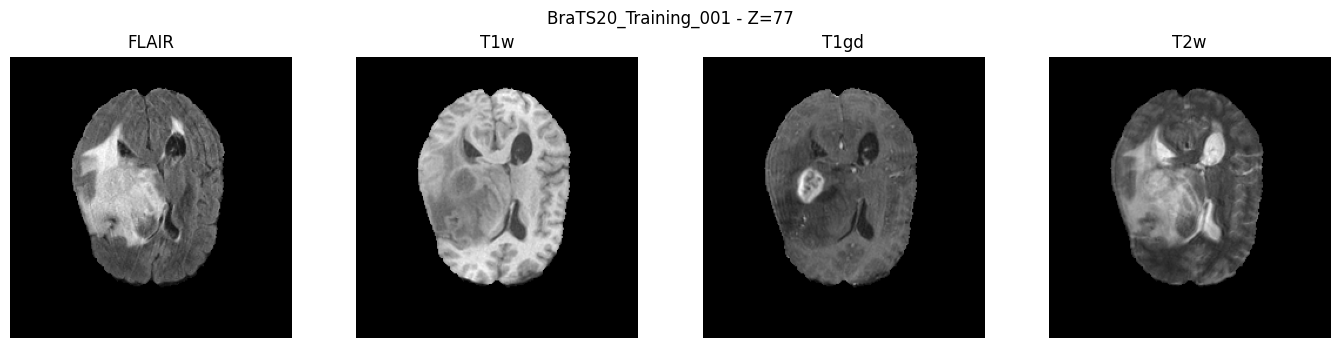

In [11]:
# Compare modalities for one subject
subject_ids = radi.obs_subject_ids
subject_id = subject_ids[0]
z_slice = 77
modalities = ["FLAIR", "T1w", "T1gd", "T2w"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
for i, mod in enumerate(modalities):
    vol = radi.collection(mod).loc[f"{subject_id}_{mod}"]
    axes[i].imshow(vol.axial(z_slice).T, cmap="gray", origin="lower")
    axes[i].set_title(mod)
    axes[i].axis("off")

plt.suptitle(f"{subject_id} - Z={z_slice}")
plt.tight_layout()
plt.show()

In [12]:
# Convert between obs_id and index using the index property
second_obs_id = flair.obs_ids[1]
idx = flair.index.get_index(second_obs_id)
obs_id = flair.index.get_key(2)

print(f"'{second_obs_id}' -> index {idx}")
print(f"index 2 -> '{obs_id}'")

'BraTS20_Training_002_FLAIR' -> index 1
index 2 -> 'BraTS20_Training_003_FLAIR'


In [13]:
# Get full obs row for a volume
flair.get_obs_row_by_obs_id(flair.obs_ids[0])

,obs_subject_id,obs_id,series_type,voxel_spacing,dimensions,datatype,bitpix,scl_slope,scl_inter,xyzt_units,spatial_units,qform_code,sform_code,axcodes,affine_json,orientation_source,source_path
0,BraTS20_Training_001,BraTS20_Training_001_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",4,16,1.0,0.0,2,mm,1,1,LPS,"[[-1.0, -0.0, -0.0, 0.0], [-0.0, -1.0, -0.0, 2...",nifti_sform,/Users/samueldsouza/.cache/radiobject/datasets...


## Collection Filtering & Lazy Mode

VolumeCollection supports the same filtering patterns as RadiObject:
- `filter()`, `head()`, `tail()`, `sample()` return views
- `lazy()` returns `CollectionQuery` for transform pipelines

In [14]:
# Filtering returns views
subset = flair.head(3)
print(f"Subset: {subset}, is_view: {subset.is_view}")

# lazy() returns CollectionQuery for transforms
cq = flair.lazy().head(3)
print(f"Query: {cq}, count: {cq.count()}")

# Materialize to numpy stack (N, X, Y, Z)
stack = cq.to_numpy_stack()
print(f"Stacked shape: {stack.shape}")

Subset: VolumeCollection('FLAIR', 3 volumes, shape=240x240x155, view), is_view: True
Query: CollectionQuery('FLAIR', 3 volumes, shape=240x240x155), count: 3
Stacked shape: (3, 240, 240, 155)


## Standalone VolumeCollection

You can create a standalone VolumeCollection from NIfTI files:

```python
from radiobject import VolumeCollection

# List of (nifti_path, subject_id) tuples
nifti_list = [
    (Path("subject1_FLAIR.nii.gz"), "subject1"),
    (Path("subject2_FLAIR.nii.gz"), "subject2"),
]

collection = VolumeCollection.from_niftis(
    uri="./my_collection",
    niftis=nifti_list,
)
```

In [15]:
flair.validate()
print("Collection validation passed")

Collection validation passed


## Next Steps

- [03_volume.ipynb](./03_volume.ipynb) - Single volume operations and partial reads
- [04_storage_configuration.ipynb](./04_storage_configuration.ipynb) - Tile orientation, compression, S3